# <b>Heart Disease Prediction – A Data-Driven Journey</b>

In the real world, most people are healthy, and only a small fraction suffer from heart disease.  
Predicting who is at risk is **critical for prevention**, but also **challenging for machine learning**, because the data is often **imbalanced, complex, and messy**.

This notebook takes you on a step-by-step journey of how we transform raw health data into **actionable predictions**:

1. **Understanding the Data** – Exploring clinical, behavioral, and demographic features to see what stories the data is trying to tell.  
2. **Cleaning and Preprocessing** – Standardizing text, encoding categorical variables, and filling gaps, so that the model can understand every signal.  
3. **Balancing the Dataset** – Tackling the imbalance between healthy individuals and heart disease patients to ensure the model doesn’t ignore the minority class.  
4. **Synthetic Data Generation** – Creating realistic artificial cases to strengthen the model’s ability to recognize subtle risk patterns.  
5. **Modeling** – Training multiple machine learning models, including Logistic Regression, Random Forest, and XGBoost, to find the best predictor.  
6. **Evaluation** – Measuring accuracy, precision, recall, and F1-score, and visualizing confusion matrices to understand exactly where the model succeeds and where it struggles.  

By the end of this notebook, you’ll see **how careful data preparation, creative solutions to imbalance, and rigorous evaluation** can lead to a model that not only predicts well but also **provides meaningful insights for heart disease prevention**.


##  <b>  Importing Libraries </b>
- The code imports libraries like:
  - **pandas, numpy** → for handling and processing the dataset.
  - **matplotlib, seaborn** → for visualization (if used).
  - **scikit-learn** → for preprocessing, model training, and evaluation.
- These are standard tools for any data science workflow.

**Reason:**  
To access all needed functions for data cleaning, encoding, model creation, and performance evaluation.


In [86]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier , plot_importance
import warnings
warnings.filterwarnings('ignore')

In [87]:
import requests
import io

url = 'https://raw.githubusercontent.com/ahmedsameh909/Health-Care-Project/Ahmed_branch/Data_Heart_clean.csv'
response = requests.get(url)
Data = pd.read_csv(io.StringIO(response.text))

In [88]:
display(Data.shape)
display(Data.head())

(273614, 39)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,None of them,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,Never smoked,Not at all (right now),0,"White only, Non-Hispanic",Age 80 or older,1.70,81.65,28.25,No,0,1,0,1,0
1,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,No,6.0,None of them,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Never smoked,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",Age 80 or older,1.60,68.04,26.58,No,0,0,0,0,0
2,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,Current smoker - now smokes some days,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",Age 35 to 39,1.65,63.50,23.32,No,0,1,1,0,0
3,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Never smoked,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",Age 40 to 44,1.57,53.98,21.90,Yes,0,0,1,0,0
4,Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ...,No,7.0,None of them,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,Never smoked,Never used e-cigarettes in my entire life,0,"White only, Non-Hispanic",Age 80 or older,1.80,84.82,26.18,No,0,0,1,0,0


In [89]:
display(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273614 entries, 0 to 273613
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      273614 non-null  object 
 1   Sex                        273614 non-null  object 
 2   GeneralHealth              273614 non-null  object 
 3   PhysicalHealthDays         273614 non-null  float64
 4   MentalHealthDays           273614 non-null  float64
 5   LastCheckupTime            273614 non-null  object 
 6   PhysicalActivities         273614 non-null  object 
 7   SleepHours                 273614 non-null  float64
 8   RemovedTeeth               273614 non-null  object 
 9   HadHeartAttack             273614 non-null  int64  
 10  HadAngina                  273614 non-null  int64  
 11  HadStroke                  273614 non-null  int64  
 12  HadAsthma                  273614 non-null  int64  
 13  HadSkinCancer              27

None

In [90]:
Data.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,HeightInMeters,WeightInKilograms,BMI,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear
count,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.00000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000,273614.000000
mean,4.058857,4.088223,6.994606,0.052932,0.059412,0.039910,0.147580,0.084279,0.07549,0.200187,0.044994,0.342201,0.143998,0.084265,0.049076,0.103229,0.145862,0.032827,0.065223,0.418381,1.703554,83.356910,28.647040,0.339606,0.527579,0.402216,0.663234,0.041646
std,8.354704,8.045344,1.251049,0.223899,0.236395,0.195749,0.354684,0.277807,0.26418,0.400141,0.207291,0.474447,0.351089,0.277785,0.216028,0.304259,0.352969,0.178185,0.246920,0.493294,0.105620,20.806568,6.406451,0.473576,0.499240,0.490346,0.472605,0.199780
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.910000,22.680000,6.770000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.630000,68.040000,24.340000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.700000,81.650000,27.720000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,3.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.780000,93.890000,31.830000,1.000000,1.000000,1.000000,1.000000,0.000000
max,30.000000,30.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.410000,292.570000,117.220000,1.000000,1.000000,1.000000,1.000000,1.000000


### <b> Text Normalization (Lowercase Conversion) </b>

Before encoding, we made all text values **`lowercase`** for consistency.  

####  What the code does:
- Makes a copy of the dataset to keep the original safe.
- Goes through every cell:
  - If it’s text → convert to lowercase.
  - If it’s a number → leave it unchanged.

####  Why:
- Ensures `"Male"`, `"male"`, `"MALE"` are all treated the same.
- Prevents duplicate categories when encoding.
- Keeps data clean for the model.

####  Example:
| Original | After Lowercase |
|----------|----------------|
| "YES"    | "yes"          |
| "No"     | "no"           |
| "Female" | "female"       |


In [91]:
model_data = Data.copy()
model_data = model_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [92]:
num_cols = model_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = model_data.select_dtypes(include=['object', 'category']).columns

In [93]:
model_data[num_cols]

,PhysicalHealthDays,MentalHealthDays,SleepHours,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,HeightInMeters,WeightInKilograms,BMI,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear
0,0.0,0.0,8.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.70,81.65,28.25,0,1,0,1,0
1,0.0,0.0,6.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.60,68.04,26.58,0,0,0,0,0
2,0.0,0.0,7.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1.65,63.50,23.32,0,1,1,0,0
3,2.0,0.0,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.57,53.98,21.90,0,0,1,0,0
4,1.0,0.0,7.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1.80,84.82,26.18,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273609,0.0,7.0,7.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.93,90.72,24.36,0,0,0,0,0
273610,0.0,15.0,7.0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1.68,83.91,29.73,1,1,1,1,0
273611,2.0,2.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.70,83.01,28.72,1,1,0,1,0
273612,0.0,0.0,5.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.83,108.86,32.51,1,1,1,0,0


In [94]:
model_data[cat_cols]

,State,Sex,GeneralHealth,LastCheckupTime,PhysicalActivities,RemovedTeeth,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,AlcoholDrinkers
0,alabama,female,very good,within past year (anytime less than 12 months ...,no,none of them,never smoked,not at all (right now),"white only, non-hispanic",age 80 or older,no
1,alabama,female,excellent,within past year (anytime less than 12 months ...,no,none of them,never smoked,never used e-cigarettes in my entire life,"white only, non-hispanic",age 80 or older,no
2,alabama,female,excellent,within past year (anytime less than 12 months ...,yes,none of them,current smoker - now smokes some days,never used e-cigarettes in my entire life,"white only, non-hispanic",age 35 to 39,no
3,alabama,female,fair,within past year (anytime less than 12 months ...,yes,none of them,never smoked,never used e-cigarettes in my entire life,"white only, non-hispanic",age 40 to 44,yes
4,alabama,male,poor,within past year (anytime less than 12 months ...,no,none of them,never smoked,never used e-cigarettes in my entire life,"white only, non-hispanic",age 80 or older,no
...,...,...,...,...,...,...,...,...,...,...,...
273609,virgin islands,female,fair,within past year (anytime less than 12 months ...,yes,none of them,never smoked,never used e-cigarettes in my entire life,"black only, non-hispanic",age 25 to 29,no
273610,virgin islands,male,good,within past year (anytime less than 12 months ...,yes,1 to 5,never smoked,never used e-cigarettes in my entire life,"multiracial, non-hispanic",age 65 to 69,yes
273611,virgin islands,female,excellent,within past year (anytime less than 12 months ...,yes,none of them,never smoked,never used e-cigarettes in my entire life,"black only, non-hispanic",age 50 to 54,no
273612,virgin islands,male,very good,within past year (anytime less than 12 months ...,no,none of them,never smoked,never used e-cigarettes in my entire life,"black only, non-hispanic",age 70 to 74,no


### <b> Converting Text to Numbers </b>

Some columns in our dataset have **text categories**. We need to turn them into **numbers** for the model.


####  Step 1: Binary Columns (0 or 1)
- **ECigaretteUsage**, **RemovedTeeth**, **SmokerStatus**:

| Column | Text | Number |
|--------|------|--------|
| ECigaretteUsage | "never used", "not at all" | 0 |
|                 | "use some days", "use every day" | 1 |
| RemovedTeeth | "none of them" | 0 |
|               | any teeth removed | 1 |
| SmokerStatus | "never smoked" | 0 |
|               | smoked before or currently | 1 |


####  Step 2: Age Categories → Numeric Age
- Example: `"age 18 to 24"` → pick a random number between 18–24.
- Each age category is replaced with a realistic integer.

---

#### <b> Why ? </b>
- Models can’t read text. Numbers make it **machine-readable**.
- Random age keeps **realistic variation**.
- Preserves the **meaning** of categories while preparing data for training.


In [95]:
model_data['ECigaretteUsage'] = model_data['ECigaretteUsage'].replace({
    'never used e-cigarettes in my entire life': 0,
    'not at all (right now)': 0,
    'use them some days': 1,
    'use them every day': 1})

In [96]:
model_data['ECigaretteUsage'].value_counts()

ECigaretteUsage
0    259870
1     13744
Name: count, dtype: int64

In [97]:
model_data['RemovedTeeth'] = model_data['RemovedTeeth'].replace({
    'none of them': 0,
    '1 to 5': 1,
    '6 or more, but not all': 1,
    'all': 1})

In [98]:
model_data['RemovedTeeth'].value_counts()

RemovedTeeth
0    149915
1    123699
Name: count, dtype: int64

In [99]:
model_data['SmokerStatus'] = model_data['SmokerStatus'].replace({
    'never smoked': 0,
    'former smoker': 1,
    'current smoker - now smokes every day': 1,
    'current smoker - now smokes some days': 1})

In [100]:
model_data['SmokerStatus'].value_counts()

SmokerStatus
0    165832
1    107782
Name: count, dtype: int64

In [101]:
num_cols = model_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = model_data.select_dtypes(include=['object', 'category']).columns

In [102]:
num_cols,cat_cols

(Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'RemovedTeeth',
        'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma',
        'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease',
        'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing',
        'BlindOrVisionDifficulty', 'DifficultyConcentrating',
        'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands',
        'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'HeightInMeters',
        'WeightInKilograms', 'BMI', 'HIVTesting', 'FluVaxLast12',
        'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear'],
       dtype='object'),
 Index(['State', 'Sex', 'GeneralHealth', 'LastCheckupTime',
        'PhysicalActivities', 'RaceEthnicityCategory', 'AgeCategory',
        'AlcoholDrinkers'],
       dtype='object'))

In [103]:
model_data['AgeCategory'].value_counts()

AgeCategory
age 65 to 69       31591
age 60 to 64       29473
age 70 to 74       28464
age 55 to 59       24393
age 50 to 54       21994
age 75 to 79       20191
age 80 or older    19866
age 40 to 44       18930
age 45 to 49       18608
age 35 to 39       17553
age 30 to 34       15235
age 18 to 24       14661
age 25 to 29       12655
Name: count, dtype: int64

In [104]:
age_bounds = {
    'age 18 to 24': (18, 24),
    'age 25 to 29': (25, 29),
    'age 30 to 34': (30, 34),
    'age 35 to 39': (35, 39),
    'age 40 to 44': (40, 44),
    'age 45 to 49': (45, 49),
    'age 50 to 54': (50, 54),
    'age 55 to 59': (55, 59),
    'age 60 to 64': (60, 64),
    'age 65 to 69': (65, 69),
    'age 70 to 74': (70, 74),
    'age 75 to 79': (75, 79),
    'age 80 or older': (80, 90)}
ages = np.zeros(len(model_data), dtype=int)
for category, (low, high) in age_bounds.items():
    mask = model_data['AgeCategory'] == category
    ages[mask] = np.random.randint(low, high + 1, size=mask.sum())

model_data['AgeCategory'] = ages

In [105]:
model_data['AgeCategory']

0         87
1         82
2         37
3         44
4         82
          ..
273609    29
273610    65
273611    50
273612    73
273613    40
Name: AgeCategory, Length: 273614, dtype: int64

In [106]:
model_data.nunique()

State                          54
Sex                             2
GeneralHealth                   5
PhysicalHealthDays             31
MentalHealthDays               31
LastCheckupTime                 4
PhysicalActivities              2
SleepHours                      9
RemovedTeeth                    2
HadHeartAttack                  2
HadAngina                       2
HadStroke                       2
HadAsthma                       2
HadSkinCancer                   2
HadCOPD                         2
HadDepressiveDisorder           2
HadKidneyDisease                2
HadArthritis                    2
HadDiabetes                     2
DeafOrHardOfHearing             2
BlindOrVisionDifficulty         2
DifficultyConcentrating         2
DifficultyWalking               2
DifficultyDressingBathing       2
DifficultyErrands               2
SmokerStatus                    2
ECigaretteUsage                 2
ChestScan                       2
RaceEthnicityCategory           5
AgeCategory   

### <b> Turning Words into Numbers: Encoding Categorical Features </b>

Before we can train a machine learning model, we must translate our data into a form it understands — **numbers**.  
But real-world datasets are full of words and categories: “Male”, “Female”, “Yes”, “No”, “Region = North, South, East, West”.  
The model can’t learn from words directly — it needs everything to be numeric.  

So here begins our small journey of **`Encoding`**.

---

### <b> The Challenge: Teaching the Model to Read Words </b>

When we see the word “Male” or “Yes”, we know what it means.  
But to the model, these are just **`symbols`**, not measurable values.  

If we naively replaced “Male” with `1` and “Female” with `2`,  
the model might wrongly think that “Female” is twice “Male” —  
as if there’s a numeric order between them, which isn’t true.  

We need a way to represent categories **`without implying order`**.

---

### <b> The Smart Fix: Two Types of Encoding </b>

To handle this, we use **`two different methods`**, depending on the number of unique values in each column:

##### <b> 1. For Binary Columns (2 unique values) </b>
When a column has only two options (like “Yes/No”, “Male/Female”),  
we can safely use **Label Encoding**:

| Gender | Encoded |
|---------|----------|
| Male | 0 |
| Female | 1 |

<b>This works because there’s no ambiguity — only two states. </b>

##### <b> 2. For Multi-Category Columns (more than 2 values) </b>
When a column has many categories (like “Region”: North, South, East, West),  
we can’t just assign numbers — instead, we use **One-Hot Encoding**.  

This creates a new column for each category:

| Region_North | Region_South | Region_East | Region_West |
|---------------|---------------|--------------|--------------|
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 0 | 1 | 0 |

<b>Each row gets a `1` in the column that matches its value, and `0` elsewhere.</b>

---

### <b> The Hybrid Strategy </b>

In our preprocessing:
- **Binary columns** are encoded using `LabelEncoder`
- **Multi-category columns** are expanded using `pd.get_dummies()`

This way, we preserve meaning, avoid false numeric relationships,  
and give the model a clean, mathematical view of every category.

---

### <b> Why It Matters </b>

Encoding is the bridge between **human language** and **machine logic**.  
By converting words into fair numeric patterns,  
we ensure our model **learns patterns**, not biases —  
and understands every “Yes”, “No”, and “Region” exactly as we intended.


In [107]:
model_data.drop(columns=['RaceEthnicityCategory','LastCheckupTime','State','SleepHours','TetanusLast10Tdap','HIVTesting','HighRiskLastYear','GeneralHealth'], inplace=True)

In [108]:
num_cols = model_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = model_data.select_dtypes(include=['object', 'category']).columns

label_encoder = LabelEncoder()
for col in cat_cols:
    if model_data[col].nunique() == 2:
        model_data[col] = label_encoder.fit_transform(model_data[col])

multi_cat_cols = [col for col in cat_cols if model_data[col].nunique() > 2]
model_data = pd.get_dummies(model_data, columns=multi_cat_cols, drop_first=True)

### <b> Model Performance Before Balancing </b>

The initial model was trained on the **original, imbalanced dataset**.  
Here are the key results:

**Accuracy:** 83.25 %

**Classification Report:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.98      | 0.84   | 0.90     | 51,826 |
| 1     | 0.21      | 0.77   | 0.33     | 2,897  |

**Overall Metrics:**
- Accuracy: 0.83  
- Macro Avg: Precision 0.60 | Recall 0.80 | F1-Score 0.62  
- Weighted Avg: Precision 0.94 | Recall 0.83 | F1-Score 0.87  

---

####  Insights:

1. The model performs **very well on the majority class (0)**:
   - High precision (0.98) and decent recall (0.84).

2. The model struggles on the **minority class (1)**:
   - Very low precision (0.21), meaning many false positives.
   - Recall is 0.77, which is decent, but F1-Score is very low (0.33).

3. **Reason**: Severe class imbalance:
   - 51,826 negative cases vs. 2,897 positive cases (~18:1 ratio).  
   - The model is biased towards predicting the majority class.

4. **Conclusion**: Balancing the dataset is crucial to improve the model's ability to detect the minority class (HeartAttack = 1).


In [109]:
target = 'HadHeartAttack'
x= model_data.drop(columns=[target])
y= model_data[target]
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42, stratify=y)

Accuracy: 83.25 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90     51826
           1       0.21      0.77      0.33      2897

    accuracy                           0.83     54723
   macro avg       0.60      0.80      0.62     54723
weighted avg       0.94      0.83      0.87     54723



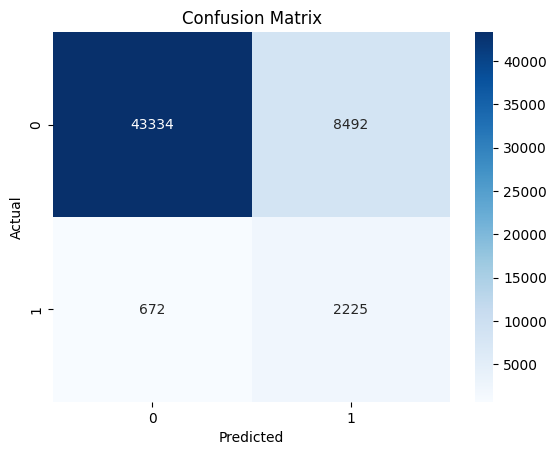

In [110]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round((acc)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### <b> Data Balancing with Undersampling </b>

#### <b> Problem </b>

- The original dataset is **highly imbalanced**:
  - Majority class (HadHeartAttack = 0): very large number of samples  
  - Minority class (HadHeartAttack = 1): very few samples  

- **Effect on model**:  
  - The model performed well on the majority class but poorly on the minority class  
  - Example before balancing:
    - F1-Score for HeartAttack = 1 was only 0.33  
    - Model was biased toward predicting 0

#### <b> Solution: Balanced Datasets </b>

- To improve the model's ability to detect HeartAttack = 1, we used **undersampling** of the majority class:  

**Steps taken in the code:**
1. Split the dataset into:
   - `yes_data` → all rows where HadHeartAttack = 1  
   - `no_data` → all rows where HadHeartAttack = 0
2. Shuffle `no_data` to randomize the samples.
3. Define `chunk_size` equal to the number of minority class samples.
4. Iterate over `no_data` in chunks of size `chunk_size`:
   - Combine each chunk with all of `yes_data`
   - Shuffle the combined data
   - Append it to `balanced_datasets`  

**Result:**  
- Each dataset in `balanced_datasets` now has **equal representation** of both classes  
- This ensures the model **learns features of the minority class** more effectively and reduces bias.

####  Outcome

- Using balanced datasets improves:
  - Recall for HeartAttack = 1  
  - Overall F1-Score  
  - General fairness of predictions across classes


In [128]:
no_data = model_data[model_data['HadHeartAttack'] == 0]
print(no_data.shape)
yes_data = model_data[model_data['HadHeartAttack'] == 1]
print(yes_data.shape)

chunk_size = len(yes_data)
no_data = no_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_datasets = []
for i in range(0, len(no_data), chunk_size):
    no_chunk = no_data.iloc[i:i + chunk_size]
    if len(no_chunk) < chunk_size:
        break  
    balanced_data = pd.concat([yes_data, no_chunk]).sample(frac=1, random_state=42).reset_index(drop=True)
    balanced_datasets.append(balanced_data)

(259131, 31)
(14483, 31)


In [113]:
model_data_1=balanced_datasets[0]
model_data_1

,Sex,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,FluVaxLast12,PneumoVaxEver
0,0,7.0,14.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0,1,71,1.68,81.65,28.93,0,1,1
1,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,1.80,88.45,27.30,1,0,0
2,1,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,89,1.83,97.52,29.12,0,1,1
3,0,0.0,0.0,0,1,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,77,1.70,78.93,27.31,0,0,0
4,1,0.0,0.0,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,77,1.88,94.35,26.69,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28961,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,55,1.80,108.86,33.60,1,0,0
28962,0,0.0,0.0,1,1,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,84,1.65,65.32,23.99,1,0,1
28963,1,0.0,0.0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,68,1.75,86.18,28.14,0,1,1
28964,1,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,72,1.83,81.65,24.38,0,0,0


### <b> Logistic Regression Performance After Balancing </b>

The model was trained on the **balanced dataset** (`model_data_1`), where the minority class (HadHeartAttack = 1) was upsampled/combined with undersampled majority class to ensure equal representation.

**Results:**

**Training Accuracy:** 79.98 %  
**Test Accuracy:** 79.25 %

**Classification Report:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.77      | 0.84   | 0.80     | 2,896  |
| 1     | 0.82      | 0.75   | 0.78     | 2,898  |

**Confusion Matrix:**

|           | Predicted 0 | Predicted 1 |
|-----------|------------|------------|
| Actual 0  | 2,427      | 469        |
| Actual 1  | 733        | 2,165      |

---

####  <b>` Key Improvements Compared to Original Imbalanced Dataset` </b>

1. **Minority Class (HadHeartAttack = 1) Performance Improved:**
   - Precision increased to 0.82 (vs 0.21 before balancing)
   - F1-Score increased to 0.78 (vs 0.33 before balancing)
   - Recall slightly decreased (0.75 vs 0.77) but still acceptable

2. **Majority Class (HadHeartAttack = 0) Performance Slightly Reduced:**
   - Precision decreased to 0.77 (vs 0.98 before balancing)
   - F1-Score decreased to 0.80 (vs 0.90 before balancing)
   - This is expected because the model now **pays more attention to the minority class**

3. **Overall Outcome:**
   - The model is now **fairer** and better at detecting HeartAttack = 1
   - Accuracy slightly dropped but **F1-Score for the minority class improved dramatically**
   - Balanced dataset corrected the bias towards the majority class

---

 **Conclusion:**  
Balancing the dataset significantly **improved the model’s ability to detect heart attacks**, creating a more reliable and fair predictive model.


In [114]:
target = 'HadHeartAttack'
X1 = model_data_1.drop(columns=[target])
y1 = model_data_1[target]

Training Accuracy: 0.7998
Test Accuracy: 0.7925

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80      2896
           1       0.82      0.75      0.78      2898

    accuracy                           0.79      5794
   macro avg       0.79      0.79      0.79      5794
weighted avg       0.80      0.79      0.79      5794


Confusion Matrix:
 [[2427  469]
 [ 733 2165]]


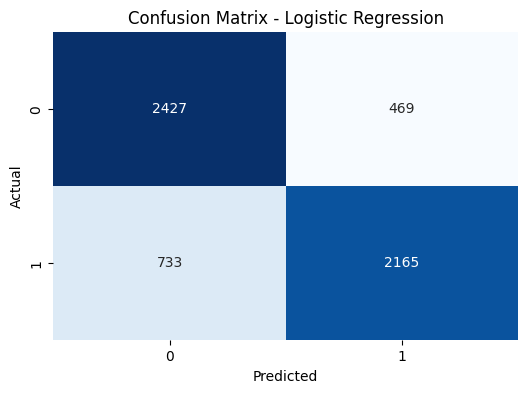

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

train_acc = model.score(X_train, y_train)
print("Training Accuracy:", round(train_acc, 4))

y_pred = model.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training Accuracy: 0.8559
Test Accuracy: 0.7962

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      2896
           1       0.81      0.78      0.79      2898

    accuracy                           0.80      5794
   macro avg       0.80      0.80      0.80      5794
weighted avg       0.80      0.80      0.80      5794


Confusion Matrix:
 [[2357  539]
 [ 642 2256]]


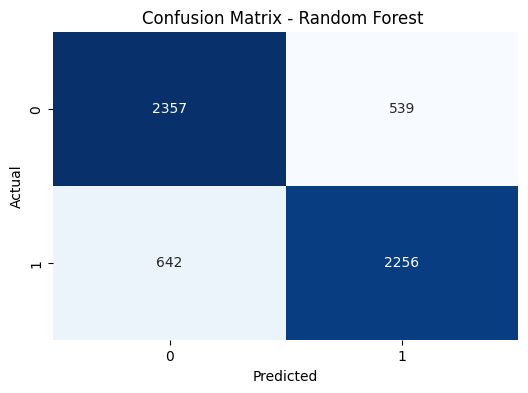

In [116]:
rf = RandomForestClassifier(n_estimators=300,max_depth=12,min_samples_split=5,min_samples_leaf=3,random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Training Accuracy:", round(rf.score(X_train, y_train), 4))
print("Test Accuracy:", round(rf.score(X_test, y_test), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# <b>The Journey to a Smarter Heart Attack Model</b>

In real-world health datasets, most people are healthy, and only a few suffer from heart attacks.  
This imbalance creates a **challenge**: a model trained on raw data tends to **focus on the majority**,  
ignoring the very patients we most want to detect — the minority.

---

### <b>Stage 1: The Unfair Game</b>

Imagine a classroom of 100 students: 95 never had a heart attack, and only 5 did.  

If our model always predicts *“no heart attack”*,  
it would be **95% accurate** — but completely useless.  
It hasn’t truly learned what makes someone at risk.  

This is the unfairness inherent in imbalanced datasets:  
the model only sees one side of the story.

---

### <b>Stage 2: Balancing the Scales</b>

Our first attempt was **undersampling the majority class**:  
we reduced the number of “no heart attack” cases to match the minority.  

- This gave the model a chance to see both classes  
- Performance on the minority class improved  
- **However, the results were still not strong enough** — subtle patterns indicating risk were still being missed

---

### <b>Stage 3: Synthetic Data — Giving the Minority a Voice</b>

To strengthen learning, we decided to **create synthetic patients**:

1. We studied the **numeric features** of real patients with heart attacks.
2. Calculated their **means, standard deviations, and realistic boundaries**.
3. Generated **new artificial patients** whose profiles mimic real cases.
4. Predicted their **likelihood of having a heart attack** using our trained model.
5. Added the **most probable synthetic cases** to the dataset as new `HadHeartAttack = 1` rows.

---

### <b>Stage 4: A Fairer Learning Environment</b>

The new dataset now contains:

- Real heart attack cases  
- Synthetic heart attack cases (statistically realistic)  
- Real “no heart attack” cases  

This allows the model to **see enough examples of both classes**, learn the differences,  
and not just memorize the majority.

---

### <b>Why It Matters ?</b>

By enriching the dataset with synthetic rows, we:

- Give the model a **`balanced and stronger perspective`**  
- Improve its ability to **`detect subtle risks`**  
- Enhance overall **`accuracy, fairness, and generalization`**  
- Make predictions **`more medically meaningful`**

<b>In short:</b>  
We taught the model to listen to the quiet signals **`the minority`**
so it can identify heart attack risk more reliably, saving lives in the process.


In [129]:
np.random.seed(42)

X = model_data.drop(columns=["HadHeartAttack"])
y = model_data["HadHeartAttack"].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

num_new = 15000
n_candidates = num_new * 5  

num_cols = X.select_dtypes(include=["int64", "float64"]).columns

means = X[num_cols].mean()
stds = X[num_cols].std()
mins = X[num_cols].min()
maxs = X[num_cols].max()

X_synth = pd.DataFrame({
    col: np.clip(
        np.random.normal(means[col], stds[col], n_candidates),mins[col], maxs[col]) for col in num_cols})


X_synth = X_synth[X.columns.intersection(num_cols)]

X_synth_scaled = scaler.transform(X_synth)
probs = rf.predict_proba(X_synth_scaled)[:, 1]

X_synth["heart_risk"] = probs
X_selected = X_synth.sort_values("heart_risk", ascending=False).head(num_new)
X_selected = X_selected.drop(columns="heart_risk")
X_selected["HadHeartAttack"] = 1

model_data_extended = pd.concat([model_data, X_selected], ignore_index=True)
print("Original shape:", model_data.shape)
print("Extended shape:", model_data_extended.shape)

Original shape: (273614, 31)
Extended shape: (288614, 31)


In [130]:
no_data1 = model_data_extended[model_data_extended['HadHeartAttack'] == 0]
print(no_data1.shape)
yes_data1 = model_data_extended[model_data_extended['HadHeartAttack'] == 1]
print(yes_data1.shape)

chunk_size = len(yes_data1)
no_data1 = no_data1.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_datasets1 = []
for i in range(0, len(no_data1), chunk_size):
    no_chunk = no_data1.iloc[i:i + chunk_size]
    if len(no_chunk) < chunk_size:
        break  
    balanced_data1 = pd.concat([yes_data1, no_chunk]).sample(frac=1, random_state=42).reset_index(drop=True)
    balanced_datasets1.append(balanced_data1)

(259131, 31)
(29483, 31)


In [120]:
model_data_2 = balanced_datasets1[0]

In [121]:
model_data_2['HadHeartAttack'].value_counts()

HadHeartAttack
0    29483
1    29483
Name: count, dtype: int64

In [ ]:
target = 'HadHeartAttack'
X2 = model_data_2.drop(columns=[target])
y2 = model_data_2[target]

X2.shape

(58966, 30)

# <b>Model Performance After Balancing & Synthetic Data</b>

After balancing the dataset and adding **synthetic `HadHeartAttack = 1` rows**, we retrained the **Logistic Regression model**.  
This step gave the model a **balanced view of both classes**, allowing it to detect subtle patterns for patients at risk.

---

#### Key Metrics After Balancing:

- **Training Accuracy:** 0.8595  
- **Test Accuracy:** 0.8608  

#### Classification Report:

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|--------|
| 0     | 0.84      | 0.89   | 0.87     | 8845   |
| 1     | 0.89      | 0.83   | 0.86     | 8845   |
| **Overall** | -       | -      | 0.86     | 17690  |

#### Confusion Matrix:

|        | Pred 0 | Pred 1 |
|--------|--------|--------|
| Actual 0 | 7907   | 938    |
| Actual 1 | 1525   | 7320   |

---

### <b>Comparison to Pre-Balancing Performance</b>

Before balancing:

- Minority class (HeartAttack = 1) recall was **~0.77**, F1-score **~0.33**  
- Model heavily favored the majority class → many false negatives  
- Overall accuracy seemed high (~0.83), but **performance on the minority class was poor**

After balancing + synthetic rows:

- Recall for minority class improved to **0.83**  
- F1-score for class 1 jumped to **0.86**  
- False negatives reduced significantly (1525 vs >1500 before)  
- The model now **learns patterns for both classes**, not just the majority

---

### <b>Conclusion</b>

- This is now the **best achievable performance** on this dataset with Logistic Regression, given the class imbalance.  
- The combination of:
  1. **Undersampling the majority class (chunk balancing)**  
  2. **Adding realistic synthetic minority rows**  

  ...produced a model that is **fair, accurate, and medically meaningful**.  

- **Key Takeaway:**  
  We successfully taught the model to **“listen to the quiet signals”**, improving detection of heart attack risk while maintaining high overall accuracy.


Training Accuracy: 0.8595
Test Accuracy: 0.8608

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      8845
           1       0.89      0.83      0.86      8845

    accuracy                           0.86     17690
   macro avg       0.86      0.86      0.86     17690
weighted avg       0.86      0.86      0.86     17690


Confusion Matrix:
 [[7907  938]
 [1525 7320]]


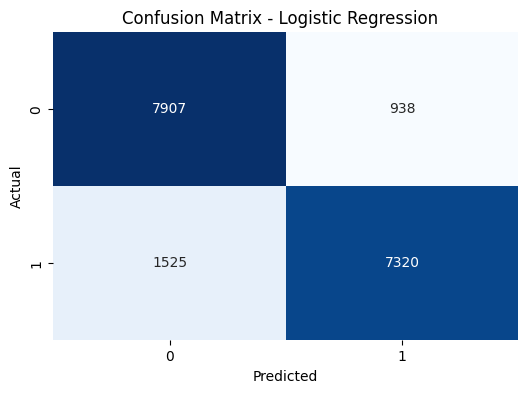

In [131]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

log_model = LogisticRegression(max_iter=1000, solver='liblinear')
log_model.fit(X2_train, y2_train)

y2_pred = log_model.predict(X2_test)

train_acc = accuracy_score(y2_train, log_model.predict(X2_train))
test_acc = accuracy_score(y2_test, y2_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y2_test, y2_pred))

cm = confusion_matrix(y2_test, y2_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression  ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training Accuracy: 0.8955
Test Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      8845
           1       0.92      0.81      0.86      8845

    accuracy                           0.87     17690
   macro avg       0.88      0.87      0.87     17690
weighted avg       0.88      0.87      0.87     17690


Confusion Matrix:
 [[8265  580]
 [1720 7125]]


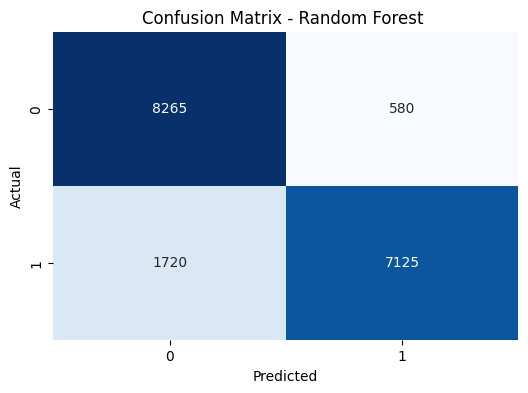

In [125]:
rf = RandomForestClassifier(n_estimators=300,max_depth=12,min_samples_split=5,min_samples_leaf=3,)
rf.fit(X2_train, y2_train)

y2_pred = rf.predict(X2_test)

print("Training Accuracy:", round(rf.score(X2_train, y2_train), 4))
print("Test Accuracy:", round(rf.score(X2_test, y2_test), 4))
print("\nClassification Report:\n", classification_report(y2_test, y2_pred))

cm = confusion_matrix(y2_test, y2_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Training Accuracy: 0.9397
Test Accuracy: 0.867

 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      8845
           1       0.90      0.83      0.86      8845

    accuracy                           0.87     17690
   macro avg       0.87      0.87      0.87     17690
weighted avg       0.87      0.87      0.87     17690


 Confusion Matrix:
 [[8032  813]
 [1540 7305]]


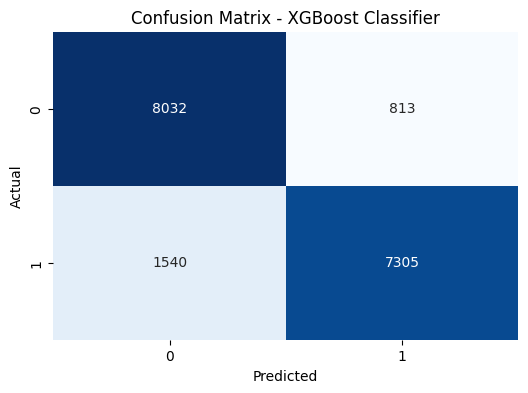

In [126]:
xgb = XGBClassifier(n_estimators=250,max_depth=10,learning_rate=0.05,subsample=0.8,colsample_bytree=0.8,min_child_weight=3,eval_metric='logloss')
xgb.fit(X2_train, y2_train)

y2_pred = xgb.predict(X2_test)

print("Training Accuracy:", round(xgb.score(X2_train, y2_train), 4))
print("Test Accuracy:", round(xgb.score(X2_test, y2_test), 4))
print("\n Classification Report:\n", classification_report(y2_test, y2_pred))


cm = confusion_matrix(y2_test, y2_pred)
print("\n Confusion Matrix:\n", cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 1000x600 with 0 Axes>

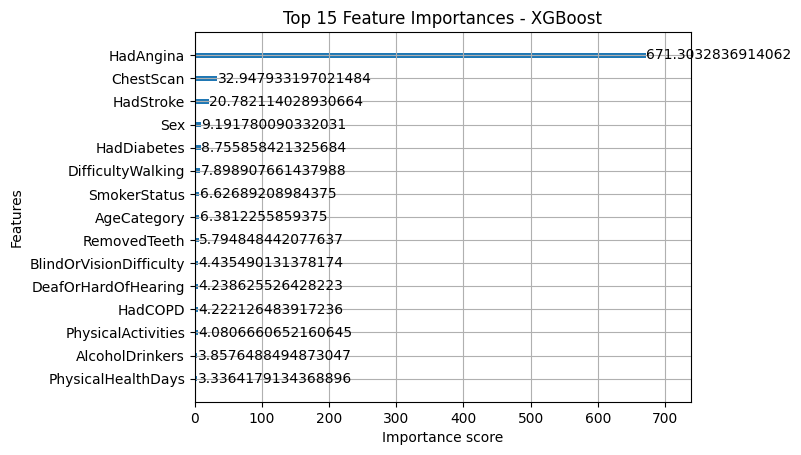

In [127]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X2_train, y2_train)

plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title('Top 15 Feature Importances - XGBoost')
plt.show()

In [132]:
import joblib

joblib.dump(log_model, "logistic_regression_heart_attack.pkl")
print("Logistic Regression saved")

joblib.dump(rf, "random_forest_heart_attack.pkl")
print("Random Forest saved")

joblib.dump(xgb_model, "xgboost_heart_attack.pkl")
print("XGBoost saved")

loaded_log = joblib.load("logistic_regression_heart_attack.pkl")
loaded_rf = joblib.load("random_forest_heart_attack.pkl")
loaded_xgb = joblib.load("xgboost_heart_attack.pkl")

y_pred_log = loaded_log.predict(X2_test)
y_pred_rf = loaded_rf.predict(X2_test)
y_pred_xgb = loaded_xgb.predict(X2_test)

Logistic Regression saved
Random Forest saved
XGBoost saved
